In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords

## Introduction

Here we will perform analysis, supervised and unsupervised methods on a set of data containing reviews of prescription drugs. The data is from: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

The dataset provides patient reviews on specific drugs along with related conditions and a 10 star patient rating reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. 

In [15]:
drugs = pd.read_csv('data/drugsComTrain_raw.tsv', delimiter='\t')

drugs.date = pd.to_datetime(drugs.date)
drugs = drugs.rename({'Unnamed: 0':'id'}, axis=1)

drugs.head()

,id,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,2016-11-27,37


With 161,297 rows of data, there will be more than enough to create some effective analysis. We should take a look at how the different classes breakdown though. The rating, the type of drug and the condition all might have different levels of imbalance.

In [16]:
drugs.shape

(161297, 7)

In [17]:
drugs.drugName.value_counts()

Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Implanon                              1102
Gabapentin                            1047
Bupropion                             1022
Venlafaxine                           1016
Miconazole                            1000
Citalopram                             995
Medroxyprogesterone                    995
Lexapro                                952
Bupropion / naltrexone                 950
Duloxetine                             934
Metronidazole                          922
Contrave                               920
Drospirenone / ethinyl estradiol       890
Depo-Prover

In [18]:
drugs.rating.value_counts()

10.0    50989
9.0     27531
1.0     21619
8.0     18890
7.0      9456
5.0      8013
2.0      6931
3.0      6513
6.0      6343
4.0      5012
Name: rating, dtype: int64

When looking at the breakdown of ratings, we see most of the ratings are either a 8, 9 or 10 star. About 1/8 are 1 star. It seems that most reviews are fairly polarizing. Reviewers are either very happy with their experience or very disappointed with it.

In [19]:
drugs.condition.value_counts()

Birth Control                                   28788
Depression                                       9069
Pain                                             6145
Anxiety                                          5904
Acne                                             5588
Bipolar Disorde                                  4224
Insomnia                                         3673
Weight Loss                                      3609
Obesity                                          3568
ADHD                                             3383
Diabetes, Type 2                                 2554
Emergency Contraception                          2463
High Blood Pressure                              2321
Vaginal Yeast Infection                          2274
Abnormal Uterine Bleeding                        2096
Bowel Preparation                                1859
ibromyalgia                                      1791
Smoking Cessation                                1780
Migraine                    

There's some data cleaning we'll have to do on the conditions, but in the meantime, you can see that far and away the most reviews are for birth control pills. There are a fair few conditions that only have 1 review, which will be tough to learn on, so if we end up going with conditions, it may be smart to limit the number of outcomes.

#### 10 Star Reviews

In [20]:
drugs[['drugName','condition','rating','review']].loc[drugs.rating == 10]

,drugName,condition,rating,review
7,Aripiprazole,Bipolar Disorde,10.0,"""Abilify changed my life. There is hope. I was..."
11,L-methylfolate,Depression,10.0,"""I have taken anti-depressants for years, with..."
18,Lamotrigine,Bipolar Disorde,10.0,"""I&#039;ve been on every medicine under the su..."
19,Nilotinib,Chronic Myelogenous Leukemia,10.0,"""I have been on Tasigna for just over 3 years ..."
21,Trazodone,Insomnia,10.0,"""I have insomnia, it&#039;s horrible. My story..."
23,Etanercept,Rheumatoid Arthritis,10.0,"""I live in Western Australia and disturbed by ..."
26,Eflornithine,Hirsutism,10.0,"""I&#039;m writing a second review on Vaniqa. ..."
27,Daytrana,ADHD,10.0,"""Hi all, My son who is 12 was diagnosed when h..."
30,Azithromycin,NaN,10.0,"""Very good response. It is so useful for me. """
32,Toradol,Pain,10.0,"""I am 30 years old. I had a multiple composite..."


In [21]:
drugs[['drugName','condition','rating','review']].loc[drugs.condition.isnull()]

,drugName,condition,rating,review
30,Azithromycin,NaN,10.0,"""Very good response. It is so useful for me. """
148,Urea,NaN,10.0,"""Accurate information."""
488,Doxepin,NaN,10.0,"""So far so good. Good for me and I can take it..."
733,Ethinyl estradiol / norgestimate,NaN,8.0,"""I haven&#039;t been on it for a long time and..."
851,Medroxyprogesterone,NaN,6.0,"""I started the shot in July 2015 and ended in ..."
1014,Acetaminophen / caffeine,NaN,10.0,"""I get migraine and have found out by taking e..."
1124,Tavaborole,NaN,10.0,"""I have struggled with nail for 8 or ten years..."
1163,Acetaminophen / butalbital / caffeine / codeine,NaN,5.0,"""I found that while this medicine does relieve..."
1253,Ethinyl estradiol / norethindrone,NaN,4.0,"""I started Loestrin and within two months I ex..."
1267,Conjugated estrogens,NaN,10.0,"""I had to have a total hysterectomy in 2009 in..."


In [ ]:
# A lot of drug name values contain a slash, might make it confusing to work with
drugs['drugName'].loc[drugs.drugName.str.contains('/')].value_counts()

#### Null Values
All of the null values are found in the condition column, and not that many either. We can move ahead by dropping the nulls here.

In [23]:
# Check the null values and put into dataframe for readability. 
nullvals = pd.DataFrame(drugs.isna().sum())
nullvals

,0
id,0
drugName,0
condition,899
review,0
rating,0
date,0
usefulCount,0


In [24]:
drugs = drugs.dropna()

#### Cleaning Up
Doing some cleaning on the condition column. Fixing some spelling errors, as well as removing all of the values that contain the span tag and replacing them with the condition that occurs the most often for the drug that is connected to the review.

In [25]:
drugs['condition'] = drugs['condition'].apply(lambda text: re.sub("(Disorde)", "Disorder", text))
drugs['condition'] = drugs['condition'].apply(lambda text: re.sub("(Cance)", "Cancer", text))

# pull out the values that contain a span tag
span_values = pd.DataFrame(drugs['drugName'].loc[drugs.condition.str.contains('</span>')].value_counts())
span_values['name'] = span_values.index

# replace the spans with the most common condition for it. 
for name in span_values['name']:
    drugs['condition'].loc[(drugs.drugName==name)&
                           (drugs.condition.str.contains('</span>'))] = drugs['condition'].loc[drugs.drugName == name].value_counts().idxmax()


In [26]:
# these should probably be the drugs where the only value contains the span tag
drugs['drugName'].loc[drugs.condition.str.contains('</span>')].value_counts()

Gadavist                               1
Rogaine Men's Extra Strength           1
Fleet Bisacodyl                        1
Fluoridex                              1
Solu-Medrol                            1
Lotrimin AF Athlete's Foot Powder      1
Dantrium                               1
Fragmin                                1
Spectracef                             1
Uroqid-Acid No2                        1
Nystop                                 1
Nutropin                               1
Fleet Phospho Soda                     1
Aerobid-M                              1
Maxidex                                1
Taztia XT                              1
Alavert D-12 Hour Allergy and Sinus    1
Lescol                                 1
Tenex                                  1
Low-Ogestrel-21                        1
Regimex                                1
Orapred                                1
Coenzyme Q10                           1
Hair Regrowth Treatment for Women      1
Latisse         

In [27]:
# Drop them!
drugs = drugs.loc[drugs.condition != drugs.condition.str.contains('</span>')]

In [31]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub("(&#039;)", "'", text)
    text = re.sub("(&amp;)", "&", text)
    text = ' '.join(text.split())
    return text

drugs.review = drugs.review.apply(lambda x: text_cleaner(x))

In [32]:
print(drugs.review[533])

"Have been on the patch for 5 months now & it's just awful, I feel nauseous all the time & get headaches and the dizziness that comes along with it. My periods are heavy & have painful cramping, some in between bleeding"


### Balance the Data
We'll move ahead with using the condition as the outcome variable. To make the data more usable, we will pull out a max-sample of 4980 rows for the top 15 conditions.

In [33]:
drugs['positive'] = np.where(drugs['rating']>7,1,0)

In [34]:
drugs['positive'].value_counts()

1    96915
0    63483
Name: positive, dtype: int64

In [35]:
drugs.rating.value_counts()

10.0    50745
9.0     27379
1.0     21504
8.0     18791
7.0      9395
5.0      7959
2.0      6879
3.0      6465
6.0      6301
4.0      4980
Name: rating, dtype: int64

In [36]:
drugs.condition.value_counts().head(15)

Birth Control                29195
Depression                    9114
Pain                          6171
Anxiety                       5928
Acne                          5597
Bipolar Disorder              4255
Insomnia                      3685
Weight Loss                   3616
Obesity                       3584
ADHD                          3408
Diabetes, Type 2              2558
Emergency Contraception       2467
High Blood Pressure           2326
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2097
Name: condition, dtype: int64

In [37]:
drugs_s = drugs.sample(frac=1, random_state=40)

conditions = pd.DataFrame(drugs.condition.value_counts().head(15))

drugs = pd.DataFrame()
for i in conditions.index:
    drugs = drugs.append(drugs_s.loc[drugs_s.condition==i][:4980])

#drugs = pd.concat([positive, not_pos])
#drugs = drugs.sample(frac=1, random_state=40)

#compare = pd.DataFrame()
#compare['five'] = drugs.positive.loc[drugs.positive==1].describe()
#compare['not'] = drugs.positive.loc[drugs.positive==0].describe()
#compare

drugs.condition.value_counts()

Acne                         4980
Depression                   4980
Pain                         4980
Birth Control                4980
Anxiety                      4980
Bipolar Disorder             4255
Insomnia                     3685
Weight Loss                  3616
Obesity                      3584
ADHD                         3408
Diabetes, Type 2             2558
Emergency Contraception      2467
High Blood Pressure          2326
Vaginal Yeast Infection      2274
Abnormal Uterine Bleeding    2097
Name: condition, dtype: int64

In [38]:
# how long it will take and hopefully speed some stuff up
from tqdm import tqdm
tqdm.pandas()

# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
# add parsed reviews into new column
drugs['review_parsed'] = drugs.review.progress_apply(nlp)

100%|██████████| 55170/55170 [16:56<00:00, 54.26it/s]


#### Create the Bag of Words

In [39]:
nlp = spacy.load('en')
from collections import Counter

# Utility function to create a list of the 200 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(300)]

common_words = pd.DataFrame()
nlp.max_length = 1500000

# loop to run NLP through all conditions / create bag of words
for i in conditions.index:
    doc = ' '.join(drugs.review.loc[drugs.condition==i][0:2500].astype(str))
    doc = nlp(doc)
    words = bag_of_words(doc)
    common_words = common_words.append(words)

common_words.head()

,0
0,-PRON-
1,period
2,be
3,not
4,month


In [40]:
common_list = set(common_words[0])

len(common_list)

1092

#### Create features from the common words

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary=common_list)

In [42]:
drugs.head(2)

,id,drugName,condition,review,rating,date,usefulCount,positive,review_parsed
152677,148521,Mirena,Birth Control,"""First one worked fine, no periods and no preg...",3.0,2017-05-10,8,0,"("", First, one, worked, fine, ,, no, periods, ..."
66136,73701,Ethinyl estradiol / norethindrone,Birth Control,"""I was on Microgestin Fe for 8 months. At firs...",3.0,2012-11-07,10,0,"("", I, was, on, Microgestin, Fe, for, 8, month..."


In [43]:
drugs = drugs.reset_index(drop=True)

df = pd.DataFrame()
df['text_sentence'] = drugs['review_parsed']
df['text_source'] = drugs['condition']
df['usefulCount'] = drugs['usefulCount']
df['rating'] = drugs['rating']
#String version of the spacy objects
df['str_sentence'] = [_.text for _ in df.text_sentence]

In [44]:
X = vectorizer.fit_transform(df['str_sentence'])

In [45]:
df2 =  pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [46]:
word_counts = pd.concat([df,df2], axis=1)
print(word_counts.shape)
word_counts.head()

(55170, 1097)


,text_sentence,text_source,usefulCount,rating,str_sentence,$,'s,-PRON-,.75,0.5,...,yes,yesterday,yi,yogurt,yr,zit,zoloft,zolpidem,zombie,zyprexa
0,"("", First, one, worked, fine, ,, no, periods, ...",Birth Control,8,3.0,"""First one worked fine, no periods and no preg...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"("", I, was, on, Microgestin, Fe, for, 8, month...",Birth Control,10,3.0,"""I was on Microgestin Fe for 8 months. At firs...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"("", A, pro, of, this, BC, is, that, it, helped...",Birth Control,3,8.0,"""A pro of this BC is that it helped clear my a...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"("", I, started, Norethindrone, back, in, Janua...",Birth Control,0,5.0,"""I started Norethindrone back in January, here...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"("", I, have, had, the, Mirena, for, 5, months,...",Birth Control,8,1.0,"""I have had the Mirena for 5 months. I HATE IT...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
word_counts.text_source.value_counts()

Acne                         4980
Depression                   4980
Pain                         4980
Birth Control                4980
Anxiety                      4980
Bipolar Disorder             4255
Insomnia                     3685
Weight Loss                  3616
Obesity                      3584
ADHD                         3408
Diabetes, Type 2             2558
Emergency Contraception      2467
High Blood Pressure          2326
Vaginal Yeast Infection      2274
Abnormal Uterine Bleeding    2097
Name: text_source, dtype: int64

## Modeling

#### Set up extra features

In [48]:
# How many of each type of word is there?
word_counts['cnt_verbs'] = [sum([1 for x in j if x.pos_ == 'VERB']) for j in word_counts.text_sentence]
word_counts['cnt_adj'] = [sum([1 for x in j if x.pos_ == 'ADJ']) for j in word_counts.text_sentence]
word_counts['cnt_prop'] = [sum([1 for x in j if x.pos_ == 'PROPN']) for j in word_counts.text_sentence]
word_counts['cnt_punct'] = [sum([1 for x in j if x.pos_ == 'PUNCT']) for j in word_counts.text_sentence]
word_counts['cnt_adv'] = [sum([1 for x in j if x.pos_ == 'ADV']) for j in word_counts.text_sentence]
word_counts['cnt_nouns'] = [sum([1 for x in j if x.pos_ == 'NOUN']) for j in word_counts.text_sentence]
word_counts['crude_sentiment'] = [j.sentiment for j in word_counts.text_sentence]

In [49]:
word_counts.columns

Index(['text_sentence', 'text_source', 'usefulCount', 'rating', 'str_sentence',
       '$', ''s', '-PRON-', '.75', '0.5',
       ...
       'zolpidem', 'zombie', 'zyprexa', 'cnt_verbs', 'cnt_adj', 'cnt_prop',
       'cnt_punct', 'cnt_adv', 'cnt_nouns', 'crude_sentiment'],
      dtype='object', length=1104)

In [50]:
word_counts['text_source'] = word_counts['text_source'].astype('category')

#### Declare and Fit the models

In [54]:
X = word_counts.drop(['text_sentence','str_sentence', 'text_source'], 1)
y = word_counts['text_source']

In [ ]:
## to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Decision Tree

In [56]:
from sklearn.metrics import roc_auc_score
from datetime import datetime

start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=20,
    max_depth=60,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

#auc = roc_auc_score(y_test, ypred_dec_tr)
#print('\nArea Under Curve:')
#print('AUC: %.3f' % auc)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9642071682335597

Test Percentage accuracy:
0.6166171246284348

Cross Validation:
[0.57432677 0.55962305 0.54059932 0.56830271 0.56619514]

Classification Report:

                           precision    recall  f1-score   support

                     ADHD       0.69      0.70      0.70       867
Abnormal Uterine Bleeding       0.64      0.65      0.65       546
                     Acne       0.75      0.79      0.77      1239
                  Anxiety       0.54      0.57      0.55      1270
         Bipolar Disorder       0.51      0.57      0.54      1072
            Birth Control       0.57      0.49      0.53      1231
               Depression       0.51      0.48      0.49      1238
         Diabetes, Type 2       0.62      0.58      0.60       618
  Emergency Contraception       0.73      0.79      0.76       572
      High Blood Pressure       0.55      0.55      0.55       555
                 Insomnia       0.61      0.58      0.60       927
 

The decision tree overfits mightily (as somewhat expected) but it runs very quickly and it's fairly decent score is a good sign for how the data will perform on a random forest or gradient boosted model. It doesn't perform particularly well or poorly on any specific class, although I would say that the low performance on classifying birth control pills is surprising, given it has one of the highest supports among the options.

### Random Forest

In [57]:
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6656596659980182

Test Percentage accuracy:
0.6459073443050823

Cross Validation:
[0.64786861 0.65253111 0.63013533 0.64941973 0.63196711]

Classification Report:
                           precision    recall  f1-score   support

                     ADHD       0.93      0.69      0.80       867
Abnormal Uterine Bleeding       0.94      0.17      0.29       546
                     Acne       0.82      0.92      0.87      1239
                  Anxiety       0.60      0.76      0.67      1270
         Bipolar Disorder       0.86      0.48      0.62      1072
            Birth Control       0.48      0.79      0.60      1231
               Depression       0.32      0.50      0.39      1238
         Diabetes, Type 2       0.91      0.47      0.62       618
  Emergency Contraception       0.95      0.85      0.90       572
      High Blood Pressure       0.84      0.47      0.60       555
                 Insomnia       0.66      0.70      0.68       927
  

Doesn't overfit like the decision tree and runs pretty fast, let's see if we can tune it a bit to increase the score.

In [78]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[30,50,100,150,300,500,700,1000], 'max_depth':[4,6,8,10,15,20]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 18.9min finished


Best score for data: {'max_depth': 20, 'n_estimators': 1000}


The best score is on the max options here, let's push it even farther

In [79]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[1000,1200,1500], 'max_depth':[20,25,30,50]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 45.6min finished


Best score for data: {'max_depth': 50, 'n_estimators': 1500}


Again, the best score is on the max options here, let's see where this stops

In [80]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[1500,1700,2000], 'max_depth':[50,75,100]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 777.0min finished


Best score for data: {'max_depth': 100, 'n_estimators': 2000}


and again.....

In [81]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[2000,2500,3000], 'max_depth':[100,200,500]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of  the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 133.6min finished


Best score for data: {'max_depth': 100, 'n_estimators': 2000}


Finally!!

In [82]:
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=2000, max_depth=100)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9999758325680314

Test Percentage accuracy:
0.845138838541289

Cross Validation:
[0.82971014 0.82246377 0.81691843 0.82908256 0.82636034]

Classification Report:
                           precision    recall  f1-score   support

                     ADHD       0.93      0.90      0.92       851
Abnormal Uterine Bleeding       0.93      0.75      0.83       539
                     Acne       0.92      0.94      0.93      1217
                  Anxiety       0.82      0.80      0.81      1270
         Bipolar Disorder       0.86      0.82      0.84      1088
            Birth Control       0.81      0.88      0.84      1231
               Depression       0.72      0.75      0.74      1238
         Diabetes, Type 2       0.93      0.88      0.90       644
  Emergency Contraception       0.97      0.96      0.96       637
      High Blood Pressure       0.88      0.81      0.85       535
                 Insomnia       0.81      0.85      0.83       960
   

After a few rounds of tuning, we end up here for the random forest. Like the decision tree, it's overfitting pretty extensively but that is often the case with these random forest models. Most of the classifiers seem to be performing pretty well on this model, with some coming out very high. Interesting that depression and weight loss are two of the lowest performers while Emergency Contraception is the highest. Two very emotional and not always clear-cut conditions are hard to predict upon and one that is high-stakes and an emergency is easier to predict.

### Gradient Boosted Decision Tree

In [83]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='deviance', max_depth=10 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

#print('\nArea Under Curve:')
#print('AUC: %.3f' % auc)

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9528735076610759

Test Percentage accuracy:
0.8271587036902777

Cross Validation:
[0.81557971 0.80615942 0.80024169 0.81119304 0.81100363]

Classification Report:
                           precision    recall  f1-score   support

                     ADHD       0.93      0.86      0.89       851
Abnormal Uterine Bleeding       0.84      0.77      0.81       539
                     Acne       0.92      0.94      0.93      1217
                  Anxiety       0.80      0.78      0.79      1270
         Bipolar Disorder       0.70      0.80      0.75      1088
            Birth Control       0.83      0.82      0.82      1231
               Depression       0.72      0.76      0.74      1238
         Diabetes, Type 2       0.93      0.87      0.90       644
  Emergency Contraception       0.97      0.95      0.96       637
      High Blood Pressure       0.92      0.81      0.86       535
                 Insomnia       0.83      0.82      0.83       960
  

Again, lots of overfitting. It's expected again, as the gradient boosted decision tree is prone to overfit. THe text accuracy comes out as a bit less than the random forest but the model also seems to be overfitting a bit less in comparison. The precision and recall scores are also performing fairly similarly across the board here as well.

# Unsupervised

In [51]:
word_counts.columns

Index(['text_sentence', 'text_source', 'usefulCount', 'rating', 'str_sentence',
       '$', ''s', '-PRON-', '.75', '0.5',
       ...
       'zolpidem', 'zombie', 'zyprexa', 'cnt_verbs', 'cnt_adj', 'cnt_prop',
       'cnt_punct', 'cnt_adv', 'cnt_nouns', 'crude_sentiment'],
      dtype='object', length=1104)

In [126]:
X = word_counts.drop(['text_sentence', 'text_source', 'usefulCount', 'str_sentence'],axis=1)

In [66]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

In [61]:
X_norm = normalize(X)
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)

X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

13792 13792
13793 13793
13792 13792
13793 13793


In [63]:
X2 = X2[:13792]
X4 = X4[:13792]
X_pca2 = X_pca2[:13792]
X_pca4 = X_pca4[:13792]
X_pca2 = X_pca2[:13792]       

# Check the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

13792 13792
13792 13792
13792 13792
13792 13792


## K Means

In [67]:
# Initialize data frames
ypred_df = pd.DataFrame()
scores_df = pd.DataFrame(columns=['cluster_pred','sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_df['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_df['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]

    
    # Creating a list of possible number of clusters to test in kmeans.
    for n_cluster in range(2, 10): 
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=n_cluster, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred_df['cluster ' + str(n_cluster) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        scores_df = scores_df.append({'cluster_pred':'cluster ' + str(n_cluster) + '_sample ' + str(counter), 
                              'sil_score':sscore}, ignore_index=True)

In [68]:
# Sorting sihoilette scores
scores_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score
0,cluster 2_sample 0,0.357532
16,cluster 2_sample 2,0.351219
8,cluster 2_sample 1,0.348376
24,cluster 2_sample 3,0.335420
9,cluster 3_sample 1,0.118910
17,cluster 3_sample 2,0.118148
1,cluster 3_sample 0,0.116789
25,cluster 3_sample 3,0.115735
10,cluster 4_sample 1,0.110854
18,cluster 4_sample 2,0.110148


Silhouette scores here are disappointingly low. It might be the large amount of features not explaining enough of variance in the data. It could also be the preprocessing of the data not working efficiently enough. While a 35% Silhoette score is disappointing, it also might be enough for us to learn something if the score doesn't really improve on the other models.

## Mean Shift

In [118]:
from sklearn import metrics
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import pairwise_distances

ypred_ms_df = pd.DataFrame()
score_ms_df = pd.DataFrame(columns=['cluster_pred','sil_score', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms_df['cluster ' + str(cntrs) + '_sample ' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms_df = score_ms_df.append({'cluster_pred':'cluster ' + str(cntrs) + '_sample ' + str(counter), 
                              'sil_score':sscore, 'quantile':n}, ignore_index=True)


In [110]:
score_ms_df.sort_values(by='sil_score', ascending=False)

,cluster_pred,sil_score,quantile
2,cluster 9_sample 0,0.302578,0.3
1,cluster 10_sample 0,0.282475,0.2
8,cluster 13_sample 2,0.251911,0.3
11,cluster 6_sample 3,0.245346,0.3
5,cluster 16_sample 1,0.223858,0.3
7,cluster 21_sample 2,0.220973,0.2
10,cluster 12_sample 3,0.219041,0.2
4,cluster 23_sample 1,0.189063,0.2
6,cluster 26_sample 2,0.177700,0.1
0,cluster 30_sample 0,0.166414,0.1


The silhouette scores for mean shift reduced from the K Means example. What is intereting is the clusters breaking out into higher samples though. We might be able to learn something from the 30 silhouette score but because of the higher score, the K means might be the better option to go forward with.

## Spectral Clustering

In [111]:
from sklearn.cluster import SpectralClustering
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [112]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
4,clust2_sample1,0.406995
12,clust2_sample3,0.405195
8,clust2_sample2,0.401914
0,clust2_sample0,0.400405
1,clust3_sample0,0.118673
9,clust3_sample2,0.117901
5,clust3_sample1,0.117390
13,clust3_sample3,0.117285
6,clust4_sample1,0.095074
14,clust4_sample3,0.094831


Silhouette scores here improves upon the K Means and the Mini Batch. This might be because of the large amount of features in the data, where the spectral is able to compile them a little bit more effectively than the K Means. But the model takes a considerable amount of time to run. Becuase of this, we'll go ahead and explore any learnings from the K Means clusters instead.

### Explore K Means
A K means with 2 clusters returns the highest scores of the models we tried. A silhouette score of 34 doesn't seem all that high, but lets see if we are able to learn anything from the clusters created.

In [69]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_norm)

In [75]:
y = word_counts['text_source']

In [70]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [79]:
# Combining the cluster to X values
df_comb = X.join(df_clust, how='inner')
df_comb['text_source'] = y
df_comb.head()

,rating,$,'s,-PRON-,.75,0.5,0.6,1,1.2,1.5,...,zyprexa,cnt_verbs,cnt_adj,cnt_prop,cnt_punct,cnt_adv,cnt_nouns,crude_sentiment,Cluster,text_source
0,3.0,0,0,0,0,0,0,0,0,0,...,0,16,6,1,14,7,12,0.0,1,Birth Control
1,3.0,0,0,0,0,0,0,0,0,0,...,0,15,3,2,9,10,13,0.0,1,Birth Control
2,8.0,0,0,0,0,0,0,0,0,0,...,0,19,17,3,13,9,25,0.0,1,Birth Control
3,5.0,0,0,0,0,0,0,0,0,0,...,0,29,6,6,27,16,18,0.0,1,Birth Control
4,1.0,0,0,0,0,0,0,0,0,0,...,0,20,10,1,19,7,25,0.0,1,Birth Control


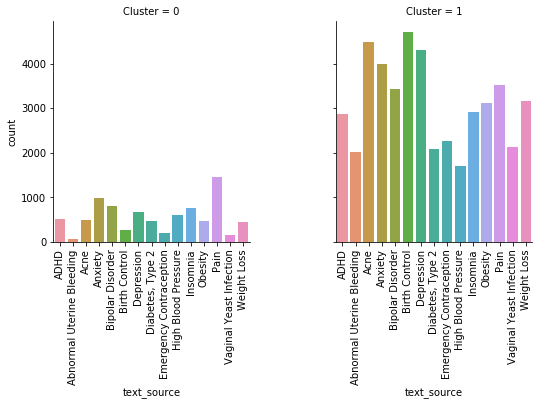

In [81]:
# Source Breakdown
g = sns.factorplot(x='text_source', col='Cluster', kind="count", data=df_comb, size=4)
g.set_xticklabels(rotation=90)

It doesn't seem to be learning all that much about the specific condition. In the 2nd cluster, there is a grouping of Acne, Anxiety, Birth Control and Depression but all of the conditions are pretty grouped together. The imbalance of size of the clusters is also throwing it off.

<Figure size 1152x576 with 0 Axes>

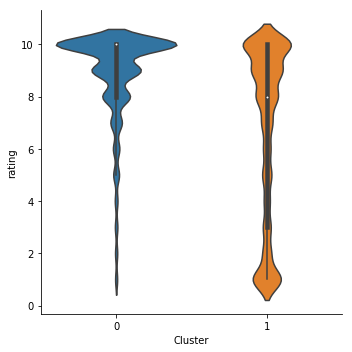

In [80]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.catplot(x='Cluster',y='rating',data=df_comb, kind="violin")

When you break it down by rating, there are is a more clear pattern that emerges. While the 2nd cluster is pretty much accross the board, the first contains a high amount of higher ratings. Almost all of the entries in cluster 1 are at least a 7 rating.

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


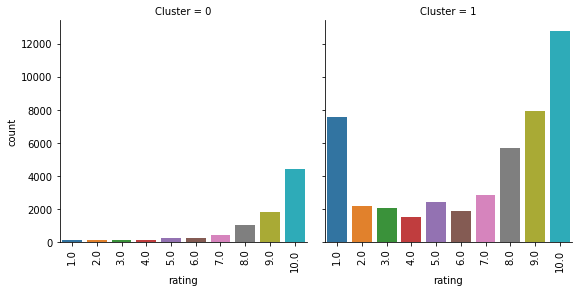

In [74]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='rating', col='Cluster', kind="count", data=df_comb, size=4)
g.set_xticklabels(rotation=90)

When you break it out into a bar graph, you can see that the highest ratings are most polarizingly found in the first cluster but because of a imbalance it actually ends up looking like the second cluster contains more of either one-star or highly rated reviews. There might be something we can learn if we up the clusters, the silhouette score was very low but there might be some learnings there to be found.

### Explore 4 Clusters

In [136]:
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

In [137]:
y = word_counts['text_source']

In [138]:
#Creating the dataframe for the cluster
df_clust = pd.DataFrame(y_pred)
df_clust.columns = ['Cluster']

In [139]:
# Combining the cluster to X values
df_comb = X.join(df_clust, how='inner')
df_comb['text_source'] = y
df_comb.head()

,rating,$,'s,-PRON-,.75,0.5,0.6,1,1.2,1.5,...,zyprexa,cnt_verbs,cnt_adj,cnt_prop,cnt_punct,cnt_adv,cnt_nouns,crude_sentiment,Cluster,text_source
0,3.0,0,0,0,0,0,0,0,0,0,...,0,16,6,1,14,7,12,0.0,2,Birth Control
1,3.0,0,0,0,0,0,0,0,0,0,...,0,15,3,2,9,10,13,0.0,2,Birth Control
2,8.0,0,0,0,0,0,0,0,0,0,...,0,19,17,3,13,9,25,0.0,0,Birth Control
3,5.0,0,0,0,0,0,0,0,0,0,...,0,29,6,6,27,16,18,0.0,2,Birth Control
4,1.0,0,0,0,0,0,0,0,0,0,...,0,20,10,1,19,7,25,0.0,0,Birth Control


In [140]:
df_comb.Cluster.value_counts()

2    22573
0    18705
1    10322
3     3570
Name: Cluster, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


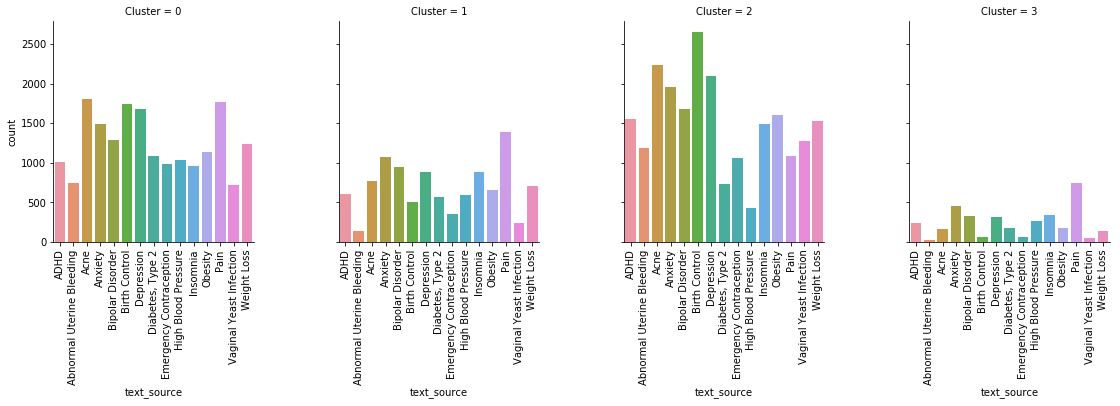

In [141]:
# Source Breakdown
g = sns.factorplot(x='text_source', col='Cluster', kind="count", data=df_comb, size=4)
g.set_xticklabels(rotation=90)

<Figure size 1152x576 with 0 Axes>

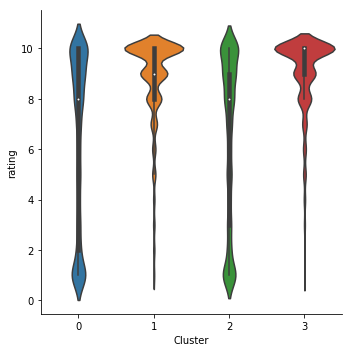

In [142]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.catplot(x='Cluster',y='rating',data=df_comb, kind="violin")

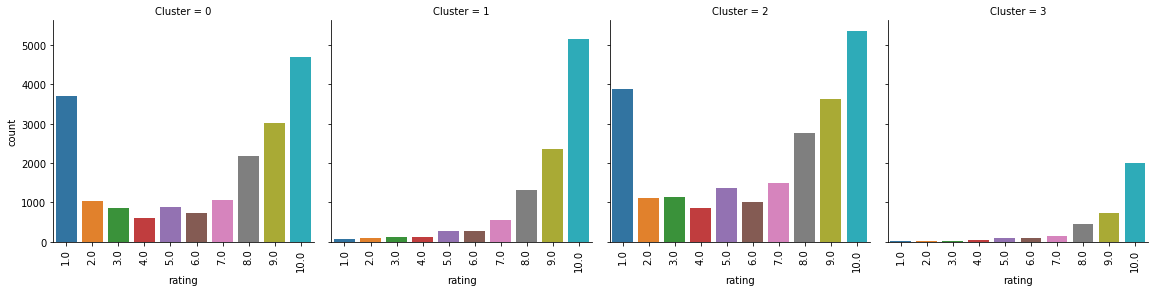

In [143]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='rating', col='Cluster', kind="count", data=df_comb, size=4)
g.set_xticklabels(rotation=90)

The four cluster solution plays out a lot like the two cluster one. Where cluster 0 & 2 represent the 2nd cluster and clusters 1 & 3 represent the first. It does level out the distribution of them a bit more, so it is a bit clearer that if the cluster is 1 or 3, the result is very very likely to be a highly rated review.

Unfortunately, there is still very very little to be learned from the condition-level information in the clusters. Possibly adding some new features could help us learn more about it, maybe increasing the count in the bag of words, or trying on TF-IDF features.

## TF-IDF

In [83]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer

In [90]:
tf_df = pd.DataFrame()
tf_df['str_sentence'] = [i.text for i in word_counts.text_sentence]
tf_df['text_source'] = word_counts.text_source
tf_df['usefulCount'] = word_counts.usefulCount
tf_df['rating'] = word_counts.rating

tf_df.head()

,str_sentence,text_source,usefulCount,rating
0,"""First one worked fine, no periods and no preg...",Birth Control,8,3.0
1,"""I was on Microgestin Fe for 8 months. At firs...",Birth Control,10,3.0
2,"""A pro of this BC is that it helped clear my a...",Birth Control,3,8.0
3,"""I started Norethindrone back in January, here...",Birth Control,0,5.0
4,"""I have had the Mirena for 5 months. I HATE IT...",Birth Control,8,1.0


In [101]:
X = tf_df['str_sentence']
y = tf_df['text_source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

#Create article vectors via LSA
vectorizer = TfidfVectorizer(max_df=.75, # drop words that occur in more than half the paragraphs
                             min_df=10, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
vectorizer.fit(X_train)
train_tfidf = vectorizer.transform(X_train)
test_tfidf = vectorizer.transform(X_test)
print("Number of features: %d" % train_tfidf.get_shape()[1])

Number of features: 6179


In [109]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, minmax_scale

svd= TruncatedSVD(1200)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa.fit(train_tfidf)
lsa_train = lsa.transform(train_tfidf)
lsa_test = lsa.transform(test_tfidf)
svd.explained_variance_ratio_.sum()

0.6993786875506391

### Random Forest LSA

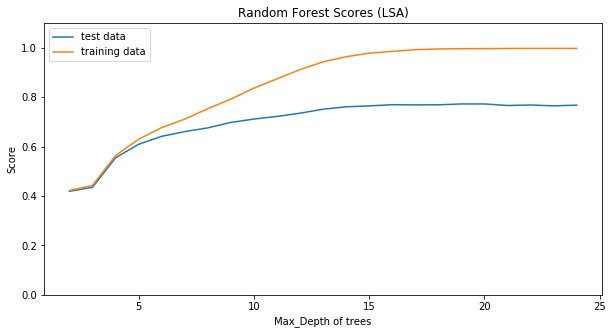

In [112]:
#Random Forest
tests = []
trains = []
for i in range(2,25,1):
  rfc_lsa = ensemble.RandomForestClassifier(n_estimators=50,
                                     max_depth=i)
  rfc_lsa.fit(lsa_train, y_train)
  trains.append(rfc_lsa.score(lsa_train, y_train))
  tests.append(rfc_lsa.score(lsa_test, y_test))
plt.figure(figsize=[10,5])
plt.title('Random Forest Scores (LSA)')
plt.plot(range(2,25,1), tests, label='test data')
plt.plot(range(2,25,1), trains, label = 'training data')
plt.xlabel('Max_Depth of trees')
plt.ylabel('Score')
plt.legend()
plt.ylim([0,1.1])
plt.show()

In [116]:
rfc_lsa = rfc_lsa = ensemble.RandomForestClassifier(n_estimators=50, max_depth=15)

rfc_lsa.fit(lsa_train, y_train)

ypred = rfc_lsa.predict(lsa_test)

print('\nClassification Report:')
print(classification_report(y_test, ypred))


Classification Report:
                           precision    recall  f1-score   support

                     ADHD       0.91      0.75      0.82      1404
Abnormal Uterine Bleeding       0.90      0.58      0.70       860
                     Acne       0.91      0.92      0.92      1961
                  Anxiety       0.67      0.75      0.71      1978
         Bipolar Disorder       0.75      0.68      0.71      1697
            Birth Control       0.72      0.84      0.78      2000
               Depression       0.57      0.66      0.61      1994
         Diabetes, Type 2       0.92      0.71      0.80       988
  Emergency Contraception       0.95      0.94      0.95       946
      High Blood Pressure       0.87      0.65      0.74       931
                 Insomnia       0.73      0.84      0.78      1481
                  Obesity       0.65      0.61      0.63      1445
                     Pain       0.80      0.86      0.83      1997
  Vaginal Yeast Infection       0.95 

With the LSA features, the Random Forest model performs far less effectively to the model with the bag of words features. A part of that might be the LSA features only accounting for 70% of the explained variance ratio. Possibly increasing the truncated SVD number might bring more variance into the equation but that would also be at the cost of some speed on the model.

# Conclusion

For our supervised explorations, it is clear that moving forward with a bag of words set of features would be the best plan of action. The LSA features didn't offer a large enough benefit in score or performance to justify their use when it was all said and done. The issue of overfitting is still a large one and ultimately will be something that needs to be reckoned with but for now, the models should suffice.

For unsupervised, unfortunately we didn't learn quite what we were expecting from our outcome variable but were able to create clusters that had learned something about our data. One of the clusters was pretty clearly identifying the top rated reviews in the dataset. While the other cluster was a mixed bag of results, at least the one was able to create some learnings.

___

___

# Old Stuff - Ignore

### TF-IDF

In [38]:
word_counts.head()

,text_sentence,text_source,usefulCount,rating,str_sentence,$,'s,-PRON-,.75,0.5,...,zolpidem,zombie,zyprexa,cnt_verbs,cnt_adj,cnt_prop,cnt_punct,cnt_adv,cnt_nouns,crude_sentiment
0,"("", First, one, worked, fine, ,, no, periods, ...",Birth Control,8,3.0,"""First one worked fine, no periods and no preg...",0,0,0,0,0,...,0,0,0,16,6,1,14,7,12,0.0
1,"("", I, was, on, Microgestin, Fe, for, 8, month...",Birth Control,10,3.0,"""I was on Microgestin Fe for 8 months. At firs...",0,0,0,0,0,...,0,0,0,15,3,2,9,10,13,0.0
2,"("", A, pro, of, this, BC, is, that, it, helped...",Birth Control,3,8.0,"""A pro of this BC is that it helped clear my a...",0,0,0,0,0,...,0,0,0,19,17,3,13,9,25,0.0
3,"("", I, started, Norethindrone, back, in, Janua...",Birth Control,0,5.0,"""I started Norethindrone back in January, here...",0,0,0,0,0,...,0,0,0,29,6,6,27,16,18,0.0
4,"("", I, have, had, the, Mirena, for, 5, months,...",Birth Control,8,1.0,"""I have had the Mirena for 5 months. I HATE IT...",0,0,0,0,0,...,0,0,0,20,10,1,19,7,25,0.0


In [48]:
tf_df = pd.DataFrame()
tf_df['str_sentence'] = [i.text for i in word_counts.text_sentence]
tf_df['text_source'] = word_counts.text_source
tf_df['usefulCount'] = word_counts.usefulCount
tf_df['rating'] = word_counts.rating

tf_df.head()

,str_sentence,text_source,usefulCount,rating
0,"""First one worked fine, no periods and no preg...",Birth Control,8,3.0
1,"""I was on Microgestin Fe for 8 months. At firs...",Birth Control,10,3.0
2,"""A pro of this BC is that it helped clear my a...",Birth Control,3,8.0
3,"""I started Norethindrone back in January, here...",Birth Control,0,5.0
4,"""I have had the Mirena for 5 months. I HATE IT...",Birth Control,8,1.0


In [ ]:
X = tf_df['str_sentence']
y = tf_df['text_source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=.75, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
speeches_tfidf=vectorizer.fit_transform(tf_df['str_sentence'])
print("Number of features: %d" % speeches_tfidf.get_shape()[1])

In [92]:
X = tf_df['str_sentence']
y = tf_df['text_source']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=.75, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
speeches_tfidf=vectorizer.fit_transform(tf_df['str_sentence'])
print("Number of features: %d" % speeches_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf= train_test_split(speeches_tfidf, y, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present 
# once in that sentence.
#print('Original sentence:', X_train)
#print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 20218


In [98]:
speeches_tfidf.head()

AttributeError: head not found

In [83]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#X_train = X_train.reset_index()
#y_train = y_train.reset_index()

abs_by_component=pd.DataFrame(X_train_lsa)
abs_by_component['str_sentence'] = X_train
abs_by_component['text_source'] = y_train

abs_by_component.head()
#for i in range(5):
#    print('Component {}:'.format(i))
#    print(abs_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 22.935606683193438


,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,str_sentence,text_source
0,0.485838,0.242780,-0.081554,0.158113,0.006388,-0.053998,0.006522,-0.027098,-0.059111,-0.006935,...,-0.064232,0.003035,0.144092,0.014379,-0.010600,-0.026813,0.053340,-0.046622,NaN,NaN
1,0.228020,0.037843,-0.120486,-0.305882,0.231735,0.085303,0.005628,-0.025811,-0.078615,-0.046621,...,0.016521,-0.057428,0.079453,-0.022090,-0.020547,0.097880,-0.001871,0.023240,NaN,NaN
2,0.294598,0.283966,-0.101724,0.053427,0.054746,-0.192590,0.046771,-0.242145,0.140978,0.158333,...,0.002947,-0.081501,-0.035217,0.082399,0.007594,0.095018,0.032486,0.003985,"""A pro of this BC is that it helped clear my a...",Birth Control
3,0.439202,-0.137371,-0.101727,-0.221112,0.104614,0.216871,0.019983,-0.003614,-0.023045,-0.030498,...,0.002282,-0.022671,-0.005625,0.005452,-0.053984,0.076172,0.028266,0.000401,NaN,NaN
4,0.304555,0.337294,-0.244157,0.248174,-0.162094,0.099875,-0.117023,0.215177,-0.010090,-0.076966,...,-0.135408,0.066197,-0.114636,-0.053537,-0.067428,-0.037156,0.009484,-0.102314,"""I have had the Mirena for 5 months. I HATE IT...",Birth Control


In [86]:
nullvals = pd.DataFrame(abs_by_component.isna().sum())
nullvals

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [88]:
abs_by_component.shape

(33103, 132)

In [75]:
y_train

1070                 Birth Control
36216                  Weight Loss
3746                 Birth Control
38654                      Obesity
47383      Emergency Contraception
44497             Diabetes, Type 2
45753             Diabetes, Type 2
34800                  Weight Loss
31213                     Insomnia
44634             Diabetes, Type 2
16873                      Anxiety
49495          High Blood Pressure
47482      Emergency Contraception
48853          High Blood Pressure
49785          High Blood Pressure
7260                    Depression
18148                      Anxiety
27050             Bipolar Disorder
53826    Abnormal Uterine Bleeding
3882                 Birth Control
36017                  Weight Loss
34611                  Weight Loss
25483             Bipolar Disorder
27735             Bipolar Disorder
17634                      Anxiety
47737      Emergency Contraception
2417                 Birth Control
2887                 Birth Control
25692             Bi

In [76]:
abs_by_component['text_source'] = y_train
#abs_by_component = abs_by_component.reset_index()

abs_by_component.head()

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,text_source
str_sentence,,,,,,,,,,,,,,,,,,,,,
"""I've been taking this bc for a few years now. Other pills made me really sick so I was excited to find a pill that worked. My boobs got ginormous (one more than the other haha) but that goes away after a while. When I started I would always get my period in the middle of the pack... I tried stopping the pills and restarting to get the period at the right time but nope it stayed in the middle. I do have to say it was really really light and maybe two days max. No cramping whatsoever. I was such a happy camper bc without bc I'd feel like I was gonna pass out from the pain. So after a year or so my periods completely stopped. That was alarming at first and I kept taking tests too make sure I wasn't pregnant. I don't worry any more.""",0.492877,0.246296,-0.082730,0.160410,0.006524,-0.054771,0.006702,-0.027496,-0.060258,-0.007057,...,-0.032664,0.058732,-0.108265,0.017336,0.040940,-0.017114,0.007623,-0.097376,0.170308,NaN
"""I started phentermine on 2/10/2015... weighed in at a whopping 282 pounds...first week and I've dropped 9 pounds.... I love it only 93 more pounds to go to reach my goal. will post again in two weeks!""",0.229938,0.038161,-0.121509,-0.308463,0.233681,0.086017,0.005574,-0.025828,-0.079311,-0.047297,...,-0.076578,0.068034,0.037008,0.009919,0.061315,-0.016194,0.001170,-0.024848,-0.081295,NaN
"""Dr suggested for heavy periods and almost anaemic. One month no bleed but then the bleed started and has now been two months of on/off light to heavy with minor to major clotting. Had ultrasound and have two fibroids. Tummy upset, cramping, fatigue and loads of money spent on liners, tampons and pads. As I took this for heavy bleeding and low iron levels, it has done nothing but cause trouble. Seeing a Gyno today for info on surgery as a permanent solution... but then I am 47 and blessed with children. BIG RISKS to consider if you are deciding on this horrible shot!""",0.285805,0.275487,-0.098693,0.051836,0.053118,-0.186823,0.045291,-0.234814,0.136804,0.153531,...,-0.151770,-0.088656,-0.055430,-0.040554,-0.031019,0.061490,-0.055299,0.017934,-0.219887,NaN
"""I am just about at the one month mark using Saxenda, started April 1. My start weight was 243 and I currently am 229.5, a loss of 13.5 lbs. I am happy to report no major side effects with the exception of very minor constipation and slight headache once in a blue moon! I started the 3 mg. dose last night and feel great. I have a protein shake for breakfast and usually take a little bit of grilled vegetables to work for lunch that my wife makes in the QVC air fryer. I have a piece of fish with some more veggies for dinner. This drug totally wipes out your appetite! You crave nothing. I also mix in 15 mins. of walking each morning on the treadmill and 1 hour at night at 3 mph. You must exercise because the drug is not magic. A definite 10.""",0.432189,-0.135180,-0.100116,-0.217597,0.102935,0.213442,0.019646,-0.003442,-0.022791,-0.030155,...,0.041650,-0.048737,-0.007884,0.011005,-0.079052,-0.008347,0.005311,-0.070273,0.063459,NaN
"""Hey everyone, unlike everyone else on here, I'm a guy and I'd like to tell you ladies to RELAX. My girlfriend and I had sex while she was ovulating and the condom broke and I came completely inside her. We got plan B about 45 minutes later, and obviously we were both freaking out because we're still youngish. I felt like the odds were against us, because we both had teen parents so I was guessing we were both pretty fertile. But, she got her period today (6 days later). It was lighter than normal and early but I know those are both symptoms of plan B. This pill is 95% effective so stop worrying, you aren't pregnant :)""",0.306523,0.339470,-0.245724,0.249784,-0.163142,0.100546,-0.117827,0.216369,-0.010122,-0.077185,...,0.047579,0.143419,-0.087656,-0.070312,0.001406,0.107697,0.040980,-0.042160,0.073387,NaN


In [60]:
abs_by_component

In [ ]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [45]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='deviance', max_depth=10 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

#print('\nArea Under Curve:')
#print('AUC: %.3f' % auc)

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

In [104]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

# Set the params
param_grid = {'n_estimators':[50,100,150,200], 'max_depth':[4,6,8,10]}

# Start the grid search again
grid_DT = GridSearchCV(clf, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 89.6min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 184.2min finished


Best score for data: {'loss': 'exponential', 'max_depth': 10, 'n_estimators': 200}


In [105]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=10 , n_estimators=200 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8784445097874486

Test Percentage accuracy:
0.7879780732152983

Cross Validation:
[0.77642426 0.77757942 0.78025729 0.7818325  0.77830288]

Area Under Curve:
AUC: 0.740

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     16048
           1       0.79      0.78      0.78     15694

   micro avg       0.79      0.79      0.79     31742
   macro avg       0.79      0.79      0.79     31742
weighted avg       0.79      0.79      0.79     31742


Duration: 2:50:44.450230


In [109]:
from sklearn.metrics import roc_auc_score

# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

auc = roc_auc_score(y_test, ypred_lr)
print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

In [96]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.1,.5,1,3], 'max_iter':[25,50,100,200,300], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=3, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.5min finished


Best score for data:
{'C': 0.5, 'max_iter': 100, 'penalty': 'l1'}


In [97]:
from sklearn.metrics import roc_auc_score
from datetime import datetime

# How long will it take
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=.5, max_iter=100, penalty='l1')
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

auc = roc_auc_score(y_test, ypred_lr)
print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.7357598924640847

Test Percentage accuracy:
0.7399974796799194

Cross Validation:
[0.7309005  0.734576   0.73074298 0.73804148 0.72978366]

Area Under Curve:
AUC: 0.740

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.74      0.74     16048
           1       0.74      0.74      0.74     15694

   micro avg       0.74      0.74      0.74     31742
   macro avg       0.74      0.74      0.74     31742
weighted avg       0.74      0.74      0.74     31742


Duration: 0:00:09.517911


### KNN

In [111]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nArea Under Curve:')
print('AUC: %.3f' % auc)

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

KeyboardInterrupt: 

____